<h1>Documentation</h1>
<h2>Jupyter setup on JUWELS nodes</h2>
<ul>
    <li><code>jutil -h</code></li>
    <li><code>jutil env activate -p training2203</code></li>
    <li><code>ln -s /p/project/training2203/pynamics/ ~/pynamics</code></li>
    <li>Copy start_jupyter-jsc.sh to $HOME/.jupyter/ <br><code>cp /p/project/training2203/pynamics/openmd/start_jupyter-jsc.sh $HOME/.jupyter/start_jupyter-jsc.sh</code></li>
</ul>
<h2>Convert Jupyter Notebook to .py</h2>
<ul>
   <li><code>cp $EBROOTJUPYTER/share/jupyter/nbconvert/templates/python/index.py.j2 ./</code></li>
   <li><code>cp $EBROOTJUPYTER/share/jupyter/nbconvert/templates/base/null.j2 ./</code></li>
   <li><code>jupyter nbconvert --to script NOTEBOOK_FILE.ipynb</code></li>
</ul>
<h2>Monitor resources with line_profiler</h2>
<ul>
    <li>Import line_profiler in respective .py file: <code>import line_profiler</code></li>
    <li>Select functions to be profiled by adding remark before start of function declaration: <code>@profile</code></li>
    <li>Run .py file: <code>kernprof -l PYTHON_FILE.py</code></li>
    <li>Show ouput: <code>python -m line_profiler lennard_jones.py.lprof</code></li>
</ul>

## 1. Simulate standard example of two particles with an unstable algorithm

In [1]:
%matplotlib inline

#import pycuda.driver as cuda
#import pycuda.autoinit
#from pycuda.compiler import SourceModule
import numpy as np 
import sys
import os
import matplotlib.pyplot as plt 
#import line_profiler

In [3]:
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"/openmd")

from SimulatorLJ import SimulatorLJ as Simulator


gamma = 0.1
dt = 0.001
coordinates = np.array([[0,1,0],[0,2,0]])
velocities = gamma*np.array([[0,1,0],[0,-1,0]])
constants = [1.0, 0.5]
box_len = 6
sim = Simulator(
    path = r"./output",
    title = "test_1",
    mass = 1,
    sim_time= 10 ,
    time_step = dt,
    initial_values = [coordinates,velocities],
    box_length = box_len,
    force=None,
    force_constants=constants,
    integrator=None,   
    periodic=True,
)

positions, velocities =sim.simulate()

/home/julian/Documents/openmd/openmd


/home/julian/Documents/openmd/openmd/openmd/SimulatorLJ.py:177: RuntimeWarning: divide by zero encountered in true_divide
  force_t = -48 * epsilon * np.power(sigma, 12) / np.power(
/home/julian/Documents/openmd/openmd/openmd/SimulatorLJ.py:179: RuntimeWarning: divide by zero encountered in true_divide
  ) - 24 * epsilon * np.power(sigma, 7) / np.power(difference, 7)
/home/julian/Documents/openmd/openmd/openmd/SimulatorLJ.py:235: RuntimeWarning: invalid value encountered in subtract
  difference = positions - particle


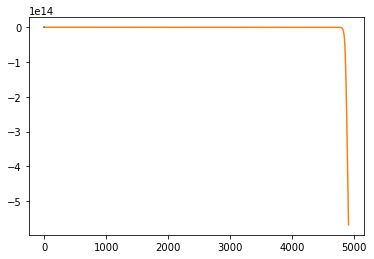

In [4]:
plt.plot(positions[0,:,:].T)

# 2. Stable algorithm

In [5]:

def force_lj_fast( positions, constants, box_length):
    """
    :param positions:
    :type positions:
    :param constants:
    :type constants:
    :param box_length:
    :type box_length:
    :return:
    :rtype:
    """
    
    epsilon, sigma = constants
    num = positions.shape[0]
    force = np.zeros((num, num, 3))
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            ###############
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            if distance > box_length / 2:
                distance -= box_length / 2
            elif distance <= -box_length / 2:
                distance += box_length / 2
            
            #################
            if distance == 0: 
                force[i,j] = 0 
                force[j,i] = 0
                break
            lj_part = (sigma / distance) ** 6
            lj_part_two = lj_part ** 2
            factor = 24 * epsilon
            factor_two = 2 * factor
            force[i, j, :] = (factor_two * lj_part_two - factor * lj_part) * (difference/distance)
            force[j, i, :] -= force[i, j, :]
    #print(np.sum(force, axis=1))
    return np.sum(force, axis=1)

In [6]:
sim.force = force_lj_fast
sim.force

<function __main__.force_lj_fast(positions, constants, box_length)>

In [19]:
gamma = 0.1
dt = 0.001
coordinates = np.load("test_samples/test_sample__n_50_s_0.25_eps_0.25_.npy")
velocities = np.zeros(coordinates.shape)
constants = [1.0, 0.5]
box_len = 6
sim = Simulator(
    path = r"./output",
    title = "test_1",
    mass = 4,
    sim_time= 1000*dt ,
    time_step = dt,
    initial_values = [coordinates,velocities],
    box_length = box_len,
    force=None,
    force_constants=constants,
    integrator=None,   
    periodic=True,
)
sim.force = force_lj_fast
sim.force

<function __main__.force_lj_fast(positions, constants, box_length)>

In [20]:
%timeit -n 1 positions, velocities =sim.simulate()

15 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
plt.plot(positions[1, 1,:].T)
plt.show()

In [ ]:
def energy_lj(positions, constants, box_length):
    """
    """
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            if distance > box_length * 0.5:
                distance -= box_length * 0.5
            elif distance <= -box_length * 0.5:
                distance += box_length * 0.5


def energy_lj_fast(positions, constants, box_length):
    """Fast energy calculation, e.g. for MC initialization

    Args:
        positions ([type]): [description]
        constants ([type]): [description]
        box_length ([type]): [description]

    Returns:
        [type]: [description]
    """
    epsilon, sigma = constants
    separations = positions[:, None, :] - positions
    # check periodic boundary conditions
    separations[separations > box_length * 0.5] -= box_length
    separations[separations <= -box_length * 0.5] += box_length

    # calculate NxN matrix with distances |r[i] - r[j]|
    # set zero values to None for calculation of acceleration

    ## Replace using CUDA numerics
    distances = np.linalg.norm(separations, axis=-1)
    distances[distances == 0] = None

    # calculate potential energy for Lennard Jones potential
    e_pot = (
        4
        * epsilon
        * (np.power((distances / sigma), -12) - np.power((distances / sigma), -6))
    )
    e_pot[np.isnan(e_pot)] = 0
    
    ## Replace using CUDA numerics
    return np.sum(e_pot)


def kinetic_energy(V, M):
    """Calculates the kinetic energy 

    Args:
        V ([type]): [description]
        M ([type]): [description]
    """

    # normed_vel =np.sum(0.5 * M*V*V,axis=0)
    # assert 1 == 2, str(len(V))
    e_kin = 0
    for i in range(len(V)):
        e_kin += 0.5 * M * np.sum(np.square(V[i, :]))
    return e_kin


def energy_gravity(positions, constants, box_length):
    """Potential energy calculation for the gravitational potential

    Args:
        positions ([type]): [description]
        constants ([type]): [description]
        box_length ([type]): [description]
    """
    G = constants[0]
    separations = positions[:, None, :] - positions

    # check periodic boundary conditions
    separations[separations > box_length * 0.5] -= box_length
    separations[separations <= -box_length * 0.5] += box_length

    # calculate NxN matrix with distances |r[i] - r[j]|
    # set zero values to None for calculation of acceleration

    ## Replace using CUDA
    distances = np.linalg.norm(separations, axis=-1)
    distances[distances == 0] = None

    # calculate potential energy for Lennard Jones potential
    e_pot = -1 * G * 1 / distances
    e_pot[np.isnan(e_pot)] = 0

    return np.sum(e_pot)

In [ ]:
energy =[]
e_kin = []
for i in range(positions.shape[2]): 
    energy.append(energy_lj_fast(positions[:,:,i], constants=constants, box_length=box_len))
    e_kin.append(kinetic_energy(velocities[:, :, i], 1))
    

In [ ]:
plt.plot(energy)
plt.show()

In [ ]:
plt.plot(e_kin)
plt.show()

In [ ]:
plt.plot(sum(energy, e_kin))
plt.show()